In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import numpy as np
import os

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2

from functions import *
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import recall_score

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device.type}')

Device used: cpu


# Hyperparameters for project

In [2]:
train_size = 0.7
test_size = 1 - train_size
num_epochs = 5
batch_size = 4
learning_rate = 0.001

# Data preprocessing


## Import the dataset
Dataset should be imported as a pytorch dataloader for batch optimization

In [3]:
# Create an empty array to store the image arrays and class
X = []
Y = []

# Define the folder paths containing the images
folder_paths = ['Dataset/Non_Demented/', 'Dataset/Very_Mild_Demented/', 'Dataset/Mild_Demented/', 'Dataset/Moderate_Demented/']
classes = [r'Non demented', r'Very mildly demented', r'mild demented', r'moderate demented']

# Loop over the images to save them in the list
for path in folder_paths:
    c = folder_paths.index(path)
    items = os.listdir(path)
    for picture in items:
        file_path = os.path.join(path, picture)
        # Open the image and convert it to a NumPy array
        img = Image.open(file_path)
        array_representation = np.asarray(img)

        # Append the NumPy array to the list
        X.append(array_representation)
        Y.append(c)

# Convert the list of image arrays to a NumPy arrayF
X = np.array(X)

from sklearn.preprocessing import MinMaxScaler # , Normalizer, StandardScaler, RobustScaler
# Transpose to make each image a row

X = X.reshape(X.shape[0], -1)

# Normalize each row (i.e., each flattened image)
X = MinMaxScaler().fit_transform(X)
print(X.max())

# Reshape back to the original shape
X = X.reshape(len(X), 128, 128, 1)

# Dynamically calculate the number of classes in dataset
num_classes = len(np.unique(Y))

X.shape

1.0000000000000002


(6400, 128, 128, 1)

In [4]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2

# Assuming you have a class named MyDataset for your dataset
class MyDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.Y[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

# Define transformations, you can adjust these based on your needs
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True)
])

# Create an instance of your dataset
dataset = MyDataset(X=X, Y=Y, transform=transform)

### Split into Test/Training sets

In [5]:
train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [int(train_size * len(dataset)), len(dataset) - int(train_size * len(dataset))]
    )

train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset, [int(train_size * len(train_dataset)), len(train_dataset) - int(train_size * len(train_dataset))]
    )

# Define DataLoader for training and test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Show example of dataset

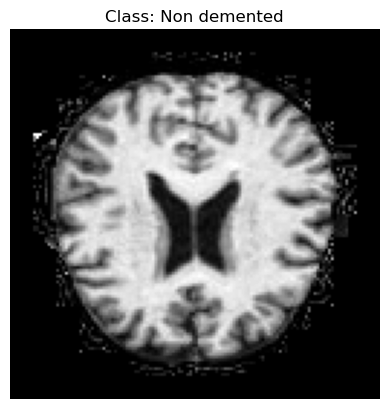

In [6]:
index_to_display = 0  # Image to show in dataset

# Get the image array and corresponding class
selected_image = X[index_to_display]
selected_class = classes[Y[index_to_display]]

# Display the image
plt.imshow(selected_image, cmap='gray')
plt.title(f'Class: {selected_class}')
plt.axis('off')  # Turn off axis labels
plt.show()

## **Data augmentation**

To augment the data before training, we will attempt to use two methods:


1.   Scaling
> Scaling is used because we wish to taken into account the varying structure size of tumors and skulls in the images.

2.   Noise Injection
> Noise injection is used to help assist the model in learning the complex patterns around the tumors and make it more robust to small changes in the data.
> We will experiment with both Gaussian (random), and salt-and-paper (random values to min. or max. values, 0 to 255) noise injection.

All combinations of these will be used to determine their effectiveness, and if they introduce any *bias*, *artifacts*, or *overfitting* both in isolation, or combination.

The order of the data augmentation will be:
1.   No Data Augmentation
2.   Scaling
3.   Noise Injection
4.   Scaling, Noise Injection

Image and shape before transformation: torch.Size([1, 128, 128])
Image and shape after transformation (scale and gaussian noise): torch.Size([1, 256, 256])


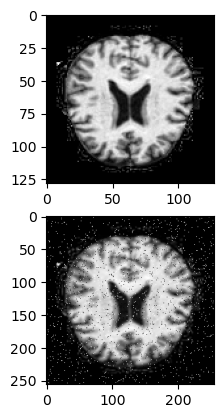

In [7]:
from torchvision.transforms import v2

aug_X = np.array(X)
# In the shape of (Sample #, Height, Width, Channels)
aug_X = aug_X.reshape(len(X), 128, 128, 1)

X_mean = X.mean()
X_std = X.std()

# def add_noise_gaussian(tensor, mean = 0, std = 0.05):
def add_noise_gaussian(tensor, mean = 0.5 * X_mean, std = 0.5 * X_std):
    """
    Parameters:
    - tensor: PyTorch tensor data type without noise (input)
    - mean: Mean of the Gaussian distribution
    - std: Standard deviation of the Gaussian distribution

    Returns:
    - tensor + noise: PyTorch tensor data type with noise (output)
    """

    noise = torch.randn(tensor.size()) * std + mean
    return tensor + noise

# def add_noise_salt_pepper(tensor, salt_prob = 0.02, pepper_prob = 0.02):
def add_noise_salt_pepper(tensor, salt_prob = 0.02, pepper_prob = 0.02):
    """
    Parameters:
    - tensor: PyTorch tensor data type without noise (input)
    - salt_prob: Probability that salt noise is added (full white)
    - pepper_prob: Probability that pepper noise is added (full black)

    Returns:
    - tensor + salt_mask = pepper_mask: PyTorch tensor data type with noise (output)
    that ensured to be between 0 and 1
    """

    salt_mask = (torch.rand_like(tensor) < salt_prob).float() # * 0.35 * X_std
    pepper_mask = (torch.rand_like(tensor) < pepper_prob).float() # * 0.35 * X_std

    # return torch.clamp((tensor + salt_mask - pepper_mask), 0, 1)
    return torch.clamp((tensor + salt_mask - pepper_mask), 0, 1)

# Abitrary values (set to double of base image height*width)
resize_x = 256
resize_y = 256

# Set resize_x and resize_y before using these transforms
# All transforms convert it to a tensor with the dimensions of (Channels, Height, Width)
transforms = {
    'none': v2.Compose([
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True)
                        ]),
    'scale': v2.Compose([
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Resize((resize_x, resize_y), antialias=True)
                        ]),
    'noise_gaussian': v2.Compose([
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Lambda(lambda x: add_noise_gaussian(x))
                        ]),
    'noise_salt_pepper': v2.Compose([
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Lambda(lambda x: add_noise_salt_pepper(x))
                        ]),
    'all_gaussian':     v2.Compose([
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Resize((resize_x, resize_y), antialias=True),
                        v2.Lambda(lambda x: add_noise_gaussian(x))
                        ]),
    'all_salt_pepper':  v2.Compose([
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Resize((resize_x, resize_y), antialias=True),
                        v2.Lambda(lambda x: add_noise_salt_pepper(x))
                        ])
}

in_img = transforms['none'](X[0])
# out_img = transforms['all_gaussian'](X[0])
out_img = transforms['all_salt_pepper'](X[0])


f, axarr = plt.subplots(2,1)

print(f'Image and shape before transformation: {in_img.shape}')
axarr[0].imshow(in_img.squeeze(), cmap='gray')

print(f'Image and shape after transformation (scale and gaussian noise): {out_img.shape}')
axarr[1].imshow(out_img.squeeze(), cmap='gray')


# Architecture of the network

In [8]:
# training
num_epochs = 100                         # Number of epochs for the training of the nn

# Learning rate und scheduler
initial_learning_rate = 0.001            # Learningrate at start
lr_steps = 15                         # Steps in lr scheduler until lr is updated
lr_gamma = 0.5                          # Faktor the lr is multiplied and updated with

In [40]:
# criterion = FocalLoss()
criterion = nn.CrossEntropyLoss()

# Now define the metrics you want to monitor during training and save them in a dict (Important: All need to take y_pred, y_cls, y_true as input (This order!))
def criterion_function(y_pred, y_cls, y_true):
    return criterion(torch.tensor(y_pred), torch.tensor(y_true))
def accuracy_function(y_pred, y_cls, y_true):
    return accuracy_score(y_true, y_cls)
def recall_function(y_pred, y_cls, y_true):
    return recall_score(y_true, y_cls, average='macro')
metrics = {'loss' : criterion_function, 'acc' : accuracy_function, 'macro recall' : recall_function}

dynamic_model = custom_ConvNet(
    input_channels = 1,
    output_size = 4,
    n_conv_layers1 = 2,
    n_filters1 = 6,
    kernel_size1 = 6,
    n_dense_layers = 3,
    n_dense_initial_nodes = 2**10,
    n_conv_layers2 = 0,
    n_filters2 = 0, 
    kernel_size2 = 0,
    operation_and_factor_filter_size=('*', 2),
    operation_and_factor_dense_network=('/', 4),
    dropout_rate=0.1,
    pooling = [2,2],
    nb_pooling_layers=1,
    activation_function = F.leaky_relu,
    evaluation_metrics=metrics,
    )

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.zeros_(m.bias)
dynamic_model.apply(init_weights)

# optimizer = torch.optim.Adam(dynamic_model.parameters(), lr=initial_learning_rate)
optimizer = torch.optim.Adam(dynamic_model.parameters(), lr=0.5)
# lr_scheduler = StepLR(optimizer, step_size=lr_steps, gamma=lr_gamma)
lr_scheduler = StepLR(optimizer, step_size=100, gamma=1)
early_stopper = EarlyStopper(dynamic_model, patience=2, min_delta=0)

train_network(dynamic_model, train_loader, criterion, optimizer, num_epochs, lr_scheduler, test_loader, device, early_stopper=early_stopper)

# If you want to save the model
# torch.save(dynamic_model, 'test_model.pth')

Device used for training: cpu
Epoch [1/100]  loss: 1.2679, acc: 0.4698, macro recall: 0.3361
Epoch [2/100]  loss: 1.2379, acc: 0.4995, macro recall: 0.3785
Epoch [3/100]  loss: 1.2900, acc: 0.4464, macro recall: 0.4199
Epoch [4/100]  loss: 1.2859, acc: 0.4484, macro recall: 0.3762
0.4484375
Early stopping triggered and model parameters has been set to best validation parameters
0.4484375
OrderedDict([('dnn.0.weight', tensor([[-0.0045,  0.0012,  0.0040,  ..., -0.0020,  0.0025, -0.0036],
        [-0.0017, -0.0038,  0.0013,  ..., -0.0025, -0.0023,  0.0048],
        [-0.0029, -0.0021,  0.0044,  ..., -0.0046,  0.0002,  0.0009],
        ...,
        [-0.0010,  0.0029,  0.0037,  ...,  0.0024, -0.0044,  0.0044],
        [-0.0007, -0.0042,  0.0020,  ...,  0.0002, -0.0008,  0.0016],
        [ 0.0024, -0.0035, -0.0011,  ..., -0.0012,  0.0035,  0.0039]])), ('dnn.0.bias', tensor([-0.0028,  0.0047, -0.0030,  ...,  0.0005,  0.0036, -0.0015])), ('dnn.1.weight', tensor([[-3.3314,  1.4592, -4.1908,  ...

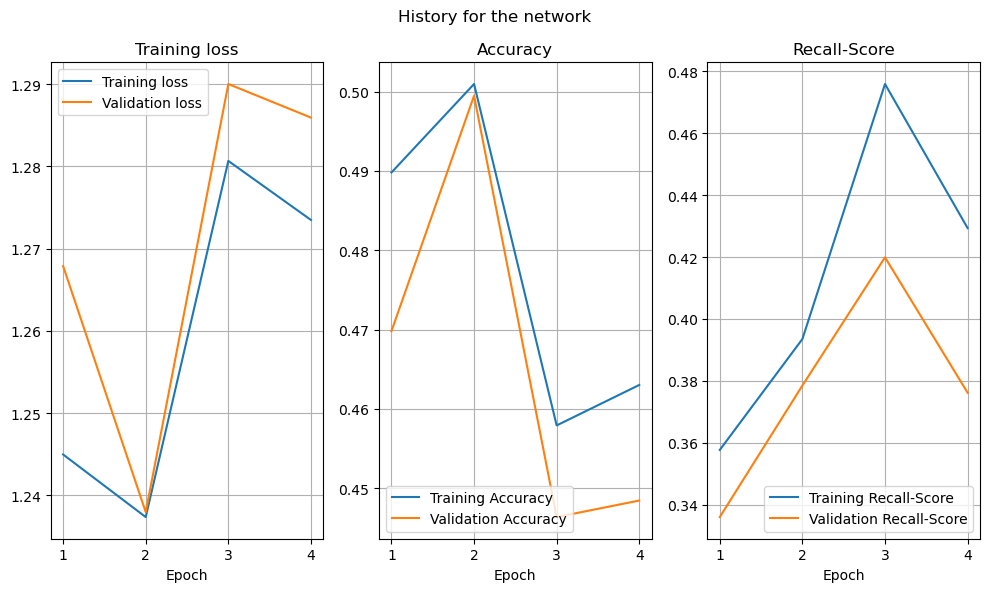

In [41]:
loss_training_hist = dynamic_model.history['loss']
training_acc_hist = dynamic_model.history['acc']
training_w_recall_hist = dynamic_model.history['macro recall']
loss_val_hist = dynamic_model.history_validation['loss']
val_acc_hist = dynamic_model.history_validation['acc']
val_w_recall_hist = dynamic_model.history_validation['macro recall']

x_epochs = np.linspace(1, len(loss_training_hist), len(loss_training_hist))
fig, ax = plt.subplots(1, 3, figsize=(10,6))
ax[0].plot(x_epochs, loss_training_hist, label = 'Training loss')
ax[0].plot(x_epochs, loss_val_hist, label = 'Validation loss')
ax[0].set(
    xlabel='Epoch',
    title='Training loss'
)

ax[1].plot(x_epochs, training_acc_hist, label='Training Accuracy')
ax[1].plot(x_epochs, val_acc_hist, label='Validation Accuracy')
ax[1].set(
    xlabel='Epoch',
    title = 'Accuracy',
)

ax[2].plot(x_epochs, training_w_recall_hist, label='Training Recall-Score')
ax[2].plot(x_epochs, val_w_recall_hist, label='Validation Recall-Score')
ax[2].set(
    xlabel='Epoch',
    title = 'Recall-Score',
)

fig.suptitle('History for the network')
for i in np.arange(len(ax)):
    ax[i].legend(loc='best')
    ax[i].grid('::')
plt.tight_layout()
plt.show()

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred, y_true = dynamic_model.evaluate(test_loader)
y_cls = np.argmax(y_pred, axis=1)
print(classification_report(y_true, y_cls))
print(confusion_matrix(y_true, y_cls))

              precision    recall  f1-score   support

           0       0.62      0.58      0.60       950
           1       0.41      0.27      0.33       665
           2       0.27      0.43      0.33       282
           3       0.04      0.22      0.06        23

    accuracy                           0.45      1920
   macro avg       0.34      0.38      0.33      1920
weighted avg       0.49      0.45      0.46      1920

[[552 189 146  63]
 [258 182 171  54]
 [ 74  66 122  20]
 [  1   8   9   5]]


## Hyperparameter search

#### Set the hyperparameter space, on which the gridsearch should be done on

The key idea behind this hyperparameter search is to split it into 3 different sequential searches.
The first search looks into the first cnn, which is assigned with the larger kernel.
The second search looks at the second cnn, which has a smaller kernel size.
Finally the parameters for the fully connected layer are searched in the third iteration.

In [9]:
# Define the metrics to monitor during training and save them in a dict
criterion = nn.CrossEntropyLoss()

def criterion_function(y_pred, y_cls, y_true):
    return criterion(torch.tensor(y_pred), torch.tensor(y_true))

def accuracy_function(y_pred, y_cls, y_true):
    return accuracy_score(y_true, y_cls)

def recall_function(y_pred, y_cls, y_true):
    return recall_score(y_true, y_cls, average='macro')

metrics = {'loss' : criterion_function, 'acc' : accuracy_function, 'macro recall' : recall_function}

default_parameters = {
    'dropout_rate' : 0.15,
    'pooling' : (2,2),
    'nb_pooling_layers' : 2,
    'evaluation_metrics' : metrics,
    'operation_and_factor_filter_size' : ('*', 2)
}

In [10]:
from itertools import product
# Phase 1
params_to_test_phase_1= ({
    'n_cnn_layers_1' : [2, 4, 6],
    'n_filters_1' : [6, 12],
    'kernel_size_1' : [5, 8],
})

value_combis = product(*[v for v in params_to_test_phase_1.values()])

hyperparameter_combinations_phase_1 = []
for combi in value_combis:
  hyperparameter_combinations_phase_1.append({key: value for key, value in zip(params_to_test_phase_1.keys(), combi)})

print(f'Total combinations of parameters in phase 1 to be tested: {len(hyperparameter_combinations_phase_1)}')

# Phase 2
params_to_test_phase_2= ({
    'n_cnn_layers_2' : [2, 4],
    'n_filters_2' : [6, 12],
    'kernel_size_2' : [3, 4],
})

value_combis = product(*[v for v in params_to_test_phase_2.values()])

hyperparameter_combinations_phase_2 = []
for combi in value_combis:
  hyperparameter_combinations_phase_2.append({key: value for key, value in zip(params_to_test_phase_2.keys(), combi)})

print(f'Total combinations of parameters in phase 2 to be tested: {len(hyperparameter_combinations_phase_2)}')

# Phase 3
params_to_test_phase_3= ({
    'num_dense_layers' : [3, 5],
    'num_dense_nodes' : [2**10, 2**11, 2**13],
    'factor' : [2, 3],
})

value_combis = product(*[v for v in params_to_test_phase_3.values()])

hyperparameter_combinations_phase_3 = []
for combi in value_combis:
  hyperparameter_combinations_phase_3.append({key: value for key, value in zip(params_to_test_phase_3.keys(), combi)})

print(f'Total combinations of parameters in phase 3 to be tested: {len(hyperparameter_combinations_phase_3)}')

Total combinations of parameters in phase 1 to be tested: 2
Total combinations of parameters in phase 2 to be tested: 2
Total combinations of parameters in phase 3 to be tested: 2


In [11]:
# Function to initialize the weights
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.zeros_(m.bias)

# Hyperparameters, which are not tested
epochs = 3
        
# Define lists to store the histories and the corresponding parameters in
hist_loss_params = {}

# Phase 1   /   Search for best cnn hyperparameters for big kernel

# Dummy variable to store the smallest loss
smallest_loss = np.inf

for i, params in enumerate(hyperparameter_combinations_phase_1):
    print(f'Phase 1: [{len(hyperparameter_combinations_phase_1)} / {i + 1}]')
    # Define model
    test_model = custom_ConvNet(1, 4, params['n_cnn_layers_1'], params['n_filters_1'], params['kernel_size_1'], 3, 2**10, **default_parameters)
    # Setup
    early_stopper = EarlyStopper(test_model, patience=4, min_delta=0)
    optimizer = torch.optim.Adam(test_model.parameters(), lr=0.01)
    scheduler = StepLR(optimizer, step_size=7, gamma=0.5)
    # Training
    train_network(test_model, train_loader, criterion, optimizer, epochs, scheduler, validation_loader, device, early_stopper)

    if np.min(test_model.history_validation['loss']) < smallest_loss:
        best_params_phase_1 = params
        # Save the best weights for the best parameters for the next search to speed up the learning
        state_dict_cnn1 = test_model.cnn1.state_dict()
        state_dict_dnn = test_model.dnn.state_dict()
        smallest_loss = np.min(test_model.history_validation['loss'])


# Phase 2   /   Search for best cnn hyperparameters for small kernel

smallest_loss = np.inf
for i, params in enumerate(hyperparameter_combinations_phase_2):
    print(f'Phase 2: [{len(hyperparameter_combinations_phase_2)} / {i + 1}]')
    # Define model
    test_model_2 = custom_ConvNet(1, 4, best_params_phase_1['n_cnn_layers_1'], best_params_phase_1['n_filters_1'], best_params_phase_1['kernel_size_1'],
                                3, 2**10,
                                params['n_cnn_layers_2'], params['n_filters_2'], params['kernel_size_2'],
                                **default_parameters,
                                )
    # Load the already trained parameters
    test_model_2.cnn1.load_state_dict(state_dict_cnn1)

    # Since first layer of dnn is variable, the fc part needs special treatment
    target_state_dict = test_model_2.dnn.state_dict()
    for name, param in state_dict_dnn.items():
        if "0" not in name:  # Skip the first layer in the source model
            target_state_dict[name].copy_(param)

    test_model_2.dnn.load_state_dict(target_state_dict)

    # Setup
    early_stopper = EarlyStopper(test_model_2, patience=4, min_delta=0)
    optimizer = torch.optim.Adam(test_model_2.parameters(), lr=0.01)
    scheduler = StepLR(optimizer, step_size=7, gamma=0.5)
    # Training
    train_network(test_model_2, train_loader, criterion, optimizer, epochs, scheduler, validation_loader, device, early_stopper)

    if np.min(test_model_2.history_validation['loss']) < smallest_loss:
        best_params_phase_2 = params
        state_dict_cnn1 = test_model_2.cnn1.state_dict()
        state_dict_cnn2 = test_model_2.cnn2.state_dict()
        smallest_loss = np.min(test_model_2.history_validation['loss'])

# Phase 3   /   Search for best fc hyperparameters

smallest_loss = np.inf

for i, params in enumerate(hyperparameter_combinations_phase_3):
    # Define model
    test_model_3 = custom_ConvNet(1, 4, best_params_phase_1['n_cnn_layers_1'], best_params_phase_1['n_filters_1'], best_params_phase_1['kernel_size_1'],
                                params['num_dense_layers'], params['num_dense_nodes'],
                                best_params_phase_2['n_cnn_layers_2'], best_params_phase_2['n_filters_2'], best_params_phase_2['kernel_size_2'],
                                operation_and_factor_dense_network=('//', params['factor']), **default_parameters
                                )
    # Load the already trained parameters
    test_model_3.cnn1.load_state_dict(state_dict_cnn1)
    test_model_3.cnn2.load_state_dict(state_dict_cnn2)
    # Setup
    early_stopper = EarlyStopper(test_model, patience=4, min_delta=0)
    optimizer = torch.optim.Adam(test_model.parameters(), lr=0.01)
    scheduler = StepLR(optimizer, step_size=7, gamma=0.5)
    # Training
    train_network(test_model, train_loader, criterion, optimizer, epochs, scheduler, validation_loader, device, early_stopper)
    # Get history
    loss_training_hist, acc_training_hist, macro_recall_training_hist = test_model.history['loss'], test_model.history['acc'], test_model.history['macro recall']
    loss_validation_hist, acc_validation_hist, macro_recall_validation_hist = test_model.history_validation['loss'], test_model.history_validation['acc'], test_model.history_validation['macro recall']
    # Store the hists etc
    hist_loss_params[tuple(params.items())] = (loss_training_hist, acc_training_hist, macro_recall_training_hist, loss_validation_hist, acc_validation_hist, macro_recall_validation_hist)

    if loss_validation_hist[-1] < smallest_loss:
        torch.save(test_model, 'best_ensample_model.pth')
        best_params_phase_3 = params
        smallest_loss = loss_validation_hist[-1]
    print(f'Phase 3: [{len(hyperparameter_combinations_phase_3)} / {i + 1}]')

# Finally get the dictionary for the best parameters and save it also (for git, so model is reproducible)
best_params_total = dict(best_params_phase_1, **best_params_phase_2, **best_params_phase_3)
with open('best_params.txt', 'w') as txt_file:
    txt_file.write(str(best_params_total))

Phase 1: [2 / 1]
Device used for training: cpu
Epoch [1/3]  loss: 1.1815, acc: 0.5789, macro recall: 0.5526
Epoch [2/3]  loss: 1.1005, acc: 0.6540, macro recall: 0.5276
Epoch [3/3]  loss: 1.0751, acc: 0.6577, macro recall: 0.6247
Phase 1: [2 / 2]
Device used for training: cpu
Epoch [1/3]  loss: 1.1729, acc: 0.5692, macro recall: 0.4113
Epoch [2/3]  loss: 1.1412, acc: 0.6183, macro recall: 0.5422
Epoch [3/3]  loss: 1.0935, acc: 0.6600, macro recall: 0.6308
Phase 2: [2 / 1]
Device used for training: cpu
Epoch [1/3]  loss: 1.1498, acc: 0.5871, macro recall: 0.5232
Epoch [2/3]  loss: 1.0975, acc: 0.6399, macro recall: 0.6868
Epoch [3/3]  loss: 1.0699, acc: 0.6674, macro recall: 0.6496
Phase 2: [2 / 2]
Device used for training: cpu
Epoch [1/3]  loss: 1.1627, acc: 0.5781, macro recall: 0.5223
Epoch [2/3]  loss: 1.1076, acc: 0.6384, macro recall: 0.5929
Epoch [3/3]  loss: 1.1099, acc: 0.6369, macro recall: 0.6718
Device used for training: cpu
Epoch [1/3]  loss: 1.2434, acc: 0.4866, macro reca